In [7]:
import graphviz
import requests
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, classification_report
from tqdm import tqdm

trashUrl = f"http://localhost:8080/api/TrashItems/dummy"
weerUrl = f"http://localhost:8080/api/Weather/"

# Load trash data
trash = pd.read_json(trashUrl)

# Convert timestamp to datetime
trash['timestamp'] = pd.to_datetime(trash['timestamp'])
trash['datum'] = trash['timestamp'].dt.date
trash['year'] = trash['timestamp'].dt.year
trash['month'] = trash['timestamp'].dt.month
trash['day'] = trash['timestamp'].dt.day
trash['weekday'] = trash['timestamp'].dt.weekday
trash['hour'] = trash['timestamp'].dt.hour

print("Data shape:", trash.shape)
print("Columns:", trash.columns.tolist())
print("Afval categorieën:", trash['litterType'].unique() if 'litterType' in trash.columns else "Geen litterType kolom")
trash.head()

Data shape: (19359, 11)
Columns: ['id', 'litterType', 'latitude', 'longitude', 'timestamp', 'datum', 'year', 'month', 'day', 'weekday', 'hour']
Afval categorieën: ['Papier' 'Plastic' 'Organisch' 'Glas']


,id,litterType,latitude,longitude,timestamp,datum,year,month,day,weekday,hour
0,6601c257-2556-4ae0-ac12-00075d62effc,Papier,51.589,4.775,2025-04-18 05:34:41,2025-04-18,2025,4,18,4,5
1,5b232aac-b2c9-4658-bfc0-000c6301404a,Plastic,51.589,4.775,2025-05-12 22:45:50,2025-05-12,2025,5,12,0,22
2,0081fa5b-f045-46cc-87e6-000cfc341d4f,Organisch,51.589,4.775,2025-06-06 22:01:32,2025-06-06,2025,6,6,4,22
3,ba89ef15-057f-486a-b41e-000daa1463b4,Plastic,51.589,4.775,2025-05-05 18:17:40,2025-05-05,2025,5,5,0,18
4,a950faaf-f429-412b-9701-000e00632d17,Plastic,51.589,4.775,2025-04-25 07:41:36,2025-04-25,2025,4,25,4,7


In [8]:
def get_all_weather_data():
    """Haal alle weerdata op uit je database"""
    weather_url = f"{weerUrl}"
    
    print(f"Trying to get all weather data from URL: {weather_url}")
    
    try:
        response = requests.get(weather_url)
        print(f"Response status: {response.status_code}")
        
        if response.status_code == 200:
            data = response.json()
            print(f"Retrieved {len(data) if isinstance(data, list) else 1} weather records")
            
            # Convert to DataFrame
            weather_df = pd.DataFrame(data)
            
            # Convert Timestamp to date
            if 'timestamp' in weather_df.columns:
                weather_df['datum'] = pd.to_datetime(weather_df['timestamp']).dt.date
                
                # Rename columns to match expected names
                weather_df = weather_df.rename(columns={
                    'temperature': 'temperatuur',
                    'weatherDescription': 'weersverwachting'
                })
            elif 'Timestamp' in weather_df.columns:
                weather_df['datum'] = pd.to_datetime(weather_df['Timestamp']).dt.date
                
                weather_df = weather_df.rename(columns={
                    'Temperature': 'temperatuur',
                    'WeatherDescription': 'weersverwachting'
                })
            
            # Select only needed columns
            if 'datum' in weather_df.columns:
                weather_df = weather_df[['datum', 'temperatuur', 'weersverwachting']]
                return weather_df
            else:
                print("Geen datum kolom gevonden in weather data")
                return pd.DataFrame()
        else:
            print(f"API call failed with status {response.status_code}")
            print(f"Response text: {response.text}")
    except Exception as e:
        print(f"Fout bij ophalen weerdata: {e}")
    
    return pd.DataFrame()

# Get weather data
weather_df = get_all_weather_data()

if not weather_df.empty:
    print("Weather data sample:")
    print(weather_df.head())
    
    # Merge weather data with trash data
    print(f"\nVoor merge:")
    print(f"Trash data shape: {trash.shape}")
    print(f"Weather data shape: {weather_df.shape}")
    
    # Ensure compatible date types
    trash['datum'] = pd.to_datetime(trash['datum']).dt.date if trash['datum'].dtype == 'object' else trash['datum']
    
    # Merge the data
    trash = pd.merge(trash, weather_df, on='datum', how='left')
    
    print(f"\nNa merge:")
    print(f"Trash data shape: {trash.shape}")
    print(f"Missing temperatuur: {trash['temperatuur'].isna().sum()}")
    print(f"Missing weersverwachting: {trash['weersverwachting'].isna().sum()}")
    
    print("\nSample van merged data:")
    print(trash[['datum', 'temperatuur', 'weersverwachting']].head())
else:
    print("Geen weerdata ontvangen, gebruik dummy data")
    # Add dummy weather data
    trash['temperatuur'] = 15.0
    trash['weersverwachting'] = 'Bewolkt'

Trying to get all weather data from URL: http://localhost:8080/api/Weather/
Response status: 200
Retrieved 62 weather records
Weather data sample:
        datum  temperatuur weersverwachting
0  2025-06-10    16.100000  Lichte motregen
1  2025-06-09    15.700001  Lichte motregen
2  2025-06-08    14.850000            Regen
3  2025-06-07    14.700000  Lichte motregen
4  2025-06-06    17.099998            Regen

Voor merge:
Trash data shape: (19359, 11)
Weather data shape: (62, 3)

Na merge:
Trash data shape: (19359, 13)
Missing temperatuur: 0
Missing weersverwachting: 0

Sample van merged data:
        datum  temperatuur      weersverwachting
0  2025-04-18    13.100000  Gedeeltelijk bewolkt
1  2025-05-12    21.250000  Gedeeltelijk bewolkt
2  2025-06-06    17.099998                 Regen
3  2025-05-05    11.599999       Lichte motregen
4  2025-04-25    12.600000       Lichte motregen


In [9]:
# Create daily dataset with categories
if 'litterType' in trash.columns:
    daily_waste_by_category = trash.groupby(['datum', 'litterType']).size().unstack(fill_value=0)
    
    # Map categories to standardized names
    category_mapping = {}
    for col in daily_waste_by_category.columns:
        col_lower = col.lower()
        if 'plastic' in col_lower:
            category_mapping[col] = 'Plastic'
        elif 'paper' in col_lower or 'papier' in col_lower:
            category_mapping[col] = 'Papier'
        elif 'organic' in col_lower or 'organisch' in col_lower or 'bio' in col_lower:
            category_mapping[col] = 'Organisch'
        elif 'glass' in col_lower or 'glas' in col_lower:
            category_mapping[col] = 'Glas'
        else:
            category_mapping[col] = 'Overig'
    
    daily_waste_by_category = daily_waste_by_category.rename(columns=category_mapping)
    
    if len(set(category_mapping.values())) < len(category_mapping):
        daily_waste_by_category = daily_waste_by_category.groupby(level=0, axis=1).sum()
    
    expected_categories = ['Plastic', 'Papier', 'Organisch', 'Glas']
    for cat in expected_categories:
        if cat not in daily_waste_by_category.columns:
            daily_waste_by_category[cat] = 0
    
    daily_waste_by_category = daily_waste_by_category[expected_categories]
    daily_waste_by_category['totaal_afval'] = daily_waste_by_category.sum(axis=1)
else:
    daily_waste_by_category = trash.groupby('datum').size().to_frame('totaal_afval')
    daily_waste_by_category['Plastic'] = 0
    daily_waste_by_category['Papier'] = 0
    daily_waste_by_category['Organisch'] = 0
    daily_waste_by_category['Glas'] = 0

# Create aggregation dictionary
agg_dict = {
    'latitude': 'median',
    'longitude': 'median',
    'year': 'first',
    'month': 'first',
    'day': 'first',
    'weekday': 'first',
    'hour': 'mean'
}

# Add weather columns to aggregation if they exist
if 'temperatuur' in trash.columns:
    agg_dict['temperatuur'] = 'mean'
if 'weersverwachting' in trash.columns:
    agg_dict['weersverwachting'] = 'first'

# Aggregate other features per day
daily_features = trash.groupby('datum').agg(agg_dict).reset_index()

# Fill missing values only if needed
if 'temperatuur' in daily_features.columns:
    missing_temp_before = daily_features['temperatuur'].isna().sum()
    if missing_temp_before > 0:
        daily_features['temperatuur'] = daily_features['temperatuur'].fillna(15.0)
else:
    daily_features['temperatuur'] = 15.0

if 'weersverwachting' in daily_features.columns:
    missing_weather_before = daily_features['weersverwachting'].isna().sum()
    if missing_weather_before > 0:
        daily_features['weersverwachting'] = daily_features['weersverwachting'].fillna('Bewolkt')
else:
    daily_features['weersverwachting'] = 'Bewolkt'

# Convert weather description to numeric values
weather_mapping = {
    'Zonnig': 0,
    'Gedeeltelijk bewolkt': 1,
    'Bewolkt': 2,
    'Regenachtig': 3,
    'Regen': 3,
    'Lichte motregen': 3,
    'Onweer': 4,
    'Sneeuw': 5
}

daily_features['weersverwachting_num'] = daily_features['weersverwachting'].map(weather_mapping).fillna(1)

# Combine features with waste counts
daily_data = pd.merge(daily_features, daily_waste_by_category.reset_index(), on='datum')

# Add extra features
daily_data['is_weekend'] = (daily_data['weekday'] >= 5).astype(int)
daily_data['seizoen'] = daily_data['month'].map({
    12: 0, 1: 0, 2: 0,  # Winter
    3: 1, 4: 1, 5: 1,    # Lente  
    6: 2, 7: 2, 8: 2,    # Zomer
    9: 3, 10: 3, 11: 3   # Herfst
})


trash.head()
daily_data.head()

,datum,latitude,longitude,year,month,day,weekday,hour,temperatuur,weersverwachting,weersverwachting_num,Plastic,Papier,Organisch,Glas,totaal_afval,is_weekend,seizoen
0,2025-04-10,51.589,4.775,2025,4,10,3,11.672489,11.750000,Gedeeltelijk bewolkt,1.0,120,41,45,23,229,0,1
1,2025-04-11,51.589,4.775,2025,4,11,4,11.330317,12.150001,Gedeeltelijk bewolkt,1.0,218,99,93,32,442,0,1
2,2025-04-12,51.589,4.775,2025,4,12,5,11.578571,16.750000,Gedeeltelijk bewolkt,1.0,127,64,59,30,280,1,1
3,2025-04-13,51.589,4.775,2025,4,13,6,11.626728,15.200000,Regen,3.0,104,44,45,24,217,1,1
4,2025-04-14,51.589,4.775,2025,4,14,0,11.441406,14.200000,Lichte motregen,3.0,135,47,50,24,256,0,1


Beschikbare features: ['latitude', 'longitude', 'year', 'month', 'day', 'weekday', 'temperatuur', 'weersverwachting_num', 'is_weekend', 'seizoen']

=== Training model voor totaal_afval ===


R² score on training set: 0.951
R² score on test set: 0.981

=== Training model voor Plastic ===
R² score on training set: 0.945
R² score on test set: 0.903

=== Training model voor Papier ===
R² score on training set: 0.966
R² score on test set: 0.992

=== Training model voor Organisch ===
R² score on training set: 0.984
R² score on test set: 0.998

=== Training model voor Glas ===
R² score on training set: 0.956
R² score on test set: 0.982

=== Decision Tree voor Totaal Afval ===


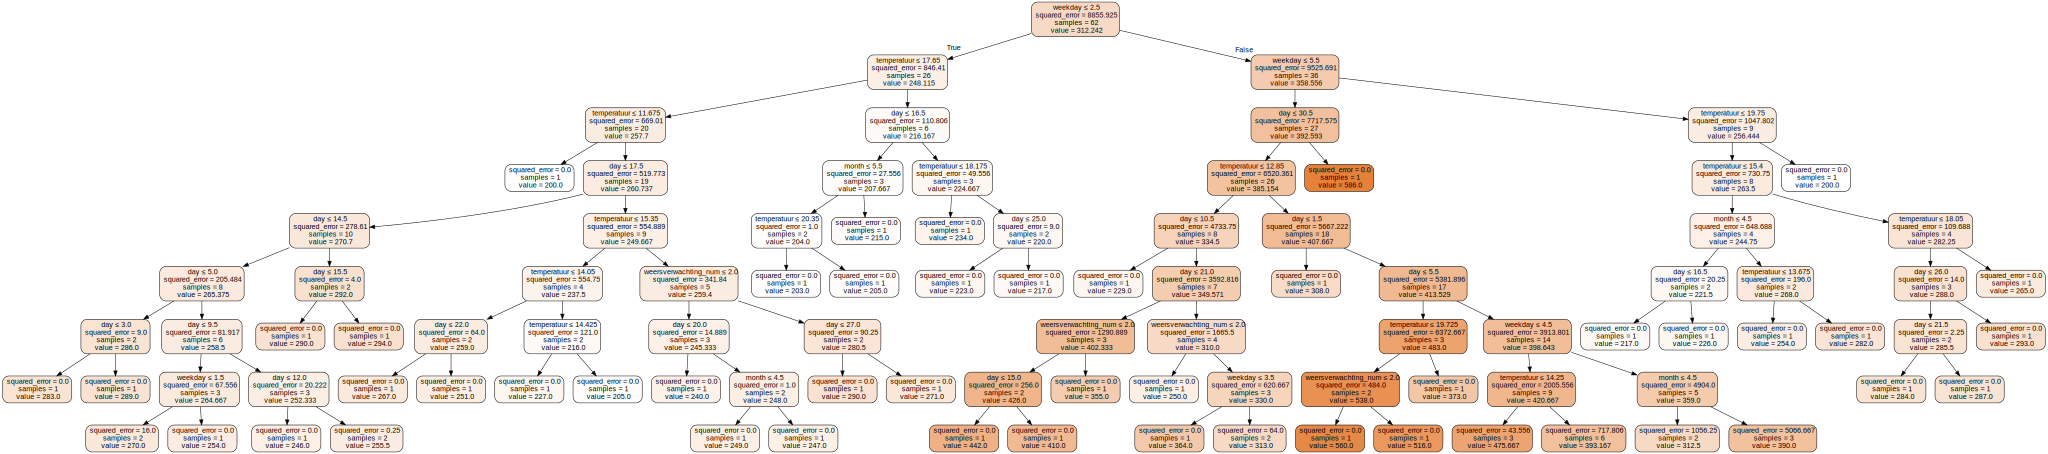

In [10]:
# ...existing code...

# Na het maken van daily_data, vervang trash door daily_data
trash = daily_data.copy()

# Fix de features lijst - voeg ontbrekende komma en hour toe
features = ['latitude', 'longitude', 'year', 'month', 'day', 'weekday',
           'temperatuur', 'weersverwachting_num', 'is_weekend', 'seizoen']

# Check welke features beschikbaar zijn
available_features = [f for f in features if f in trash.columns]
print("Beschikbare features:", available_features)

# Train models voor totaal + 4 categorieën
targets = ['totaal_afval', 'Plastic', 'Papier', 'Organisch', 'Glas']
models = {}

for target_name in targets:
    print(f"\n=== Training model voor {target_name} ===")
    
    target = trash[target_name]
    
    # Gebruik regressie in plaats van classificatie
    trash_train, trash_test = train_test_split(
        trash, test_size=0.3, random_state=42
    )

    dt = DecisionTreeRegressor(max_depth=8)  # Verander naar Regressor
    dt.fit(trash[available_features], target)

    predictions_train = dt.predict(trash_train[available_features])
    predictions_test = dt.predict(trash_test[available_features])

    # Gebruik R² score voor regressie accuracy
    from sklearn.metrics import r2_score
    accuracy_train = r2_score(trash_train[target_name], predictions_train)
    accuracy_test = r2_score(trash_test[target_name], predictions_test)

    print(f"R² score on training set: {accuracy_train:.3f}")
    print(f"R² score on test set: {accuracy_test:.3f}")
    
    # Sla model op
    models[target_name] = dt

def plot_tree_regression(model, features, title="decision_tree"):
    # Generate plot data
    dot_data = tree.export_graphviz(model, out_file=None, 
        feature_names=features,  
        filled=True, rounded=True,  
        special_characters=True)  

    # Turn into graph using graphviz
    graph = graphviz.Source(dot_data)  

    # Write out a pdf
    graph.render(title)

    # Display in the notebook
    return graph 

# Plot decision tree voor totaal afval
print("\n=== Decision Tree voor Totaal Afval ===")
plot_tree_regression(models['totaal_afval'], available_features, "decision_tree_totaal")

# Feature importance voor alle modellen

In [11]:
def predict_single_day(date, latitude=51.589, longitude=4.775, 
                      temperatuur=15.0, weersverwachting='Bewolkt'):
    """
    Voorspel afval voor één specifieke dag
    
    Parameters:
    - date: datetime of string in format 'YYYY-MM-DD'
    - latitude: latitude coordinaat (default: 51.589)
    - longitude: longitude coordinaat (default: 4.775) 
    - temperatuur: temperatuur in graden Celsius (default: 15.0)
    - weersverwachting: weer beschrijving (default: 'Bewolkt')
    
    Returns:
    - Dictionary met voorspellingen voor alle afval categorieën
    """
    
    # Convert date to datetime if string
    if isinstance(date, str):
        date = pd.to_datetime(date)
    
    # Extract date features
    year = date.year
    month = date.month
    day = date.day
    weekday = date.weekday()
    hour = 12.0  # Default hour (middag)
    
    # Calculate derived features
    is_weekend = 1 if weekday >= 5 else 0
    seizoen_mapping = {
        12: 0, 1: 0, 2: 0,  # Winter
        3: 1, 4: 1, 5: 1,   # Lente  
        6: 2, 7: 2, 8: 2,   # Zomer
        9: 3, 10: 3, 11: 3  # Herfst
    }
    seizoen = seizoen_mapping[month]
    
    # Map weather description to numeric
    weather_mapping = {
        'Zonnig': 0,
        'Gedeeltelijk bewolkt': 1,
        'Bewolkt': 2,
        'Regenachtig': 3,
        'Regen': 3,
        'Lichte motregen': 3,
        'Onweer': 4,
        'Sneeuw': 5
    }
    weersverwachting_num = weather_mapping.get(weersverwachting, 1)
    
    # Create input data
    input_data = pd.DataFrame({
        'latitude': [latitude],
        'longitude': [longitude],
        'year': [year],
        'month': [month],
        'day': [day],
        'weekday': [weekday],
        'hour': [hour],
        'temperatuur': [temperatuur],
        'weersverwachting_num': [weersverwachting_num],
        'is_weekend': [is_weekend],
        'seizoen': [seizoen]
    })
    
    # Make predictions with all models
    predictions = {}
    for target_name, model in models.items():
        prediction = model.predict(input_data[available_features])[0]
        predictions[target_name] = max(0, round(prediction))
    
    return predictions

# Example usage - predict waste for a specific day
import datetime

# Voorspelling voor morgen
tomorrow = datetime.date.today() + datetime.timedelta(days=1)
prediction = predict_single_day(
    date=tomorrow,
    temperatuur=25.0,
    weersverwachting='Zonnig'
)

print(f"Afval voorspelling voor {tomorrow}:")
for category, amount in prediction.items():
    print(f"  {category}: {amount} items")

# Voorspelling voor een specifieke datum
specific_date = "2025-06-13"  # Bijvoorbeeld zomervakantie
summer_prediction = predict_single_day(
    date=specific_date,
    temperatuur=20.0,
    weersverwachting='Zonnig'
)

print(f"\nAfval voorspelling voor {specific_date}:")
for category, amount in summer_prediction.items():
    print(f"  {category}: {amount} items")

Afval voorspelling voor 2025-06-13:
  totaal_afval: 393 items
  Plastic: 228 items
  Papier: 81 items
  Organisch: 69 items
  Glas: 35 items

Afval voorspelling voor 2025-06-13:
  totaal_afval: 393 items
  Plastic: 228 items
  Papier: 81 items
  Organisch: 69 items
  Glas: 30 items


In [12]:
# def predict_future_waste(date, latitude=51.589, longitude=4.775, 
#                         temperatuur=15.0, weersverwachting='Bewolkt'):
#     """
#     Voorspel afval voor een specifieke datum in de toekomst
    
#     Parameters:
#     - date: datetime of string in format 'YYYY-MM-DD'
#     - latitude: latitude coordinaat (default: 51.589)
#     - longitude: longitude coordinaat (default: 4.775) 
#     - temperatuur: temperatuur in graden Celsius (default: 15.0)
#     - weersverwachting: weer beschrijving (default: 'Bewolkt')
    
#     Returns:
#     - Dictionary met voorspellingen voor alle afval categorieën
#     """
    
#     # Convert date to datetime if string
#     if isinstance(date, str):
#         date = pd.to_datetime(date)
    
#     # Extract date features
#     year = date.year
#     month = date.month
#     day = date.day
#     weekday = date.weekday()
#     hour = 12.0  # Default hour (middag)
    
#     # Calculate derived features
#     is_weekend = 1 if weekday >= 5 else 0
#     seizoen_mapping = {
#         12: 0, 1: 0, 2: 0,  # Winter
#         3: 1, 4: 1, 5: 1,   # Lente  
#         6: 2, 7: 2, 8: 2,   # Zomer
#         9: 3, 10: 3, 11: 3  # Herfst
#     }
#     seizoen = seizoen_mapping[month]
    
#     # Map weather description to numeric
#     weather_mapping = {
#         'Zonnig': 0,
#         'Gedeeltelijk bewolkt': 1,
#         'Bewolkt': 2,
#         'Regenachtig': 3,
#         'Regen': 3,
#         'Lichte motregen': 3,
#         'Onweer': 4,
#         'Sneeuw': 5
#     }
#     weersverwachting_num = weather_mapping.get(weersverwachting, 1)
    
#     # Create input data
#     input_data = pd.DataFrame({
#         'latitude': [latitude],
#         'longitude': [longitude],
#         'year': [year],
#         'month': [month],
#         'day': [day],
#         'weekday': [weekday],
#         'hour': [hour],
#         'temperatuur': [temperatuur],
#         'weersverwachting_num': [weersverwachting_num],
#         'is_weekend': [is_weekend],
#         'seizoen': [seizoen]
#     })
    
#     # Make predictions with all models
#     predictions = {}
#     for target_name, model in models.items():
#         prediction = model.predict(input_data[available_features])[0]
#         predictions[target_name] = max(0, round(prediction))  # Ensure non-negative integers
    
#     return predictions

# # Example usage - predict waste for tomorrow
# import datetime
# tomorrow = datetime.date.today() + datetime.timedelta(days=1)

# print(f"\n=== Voorspelling voor {tomorrow} ===")
# prediction = predict_future_waste(
#     date=tomorrow,
#     temperatuur=5.0,  # Average temperature
#     weersverwachting='Zonnig'
# )

# for category, amount in prediction.items():
#     print(f"{category}: {amount} items")

# # Predict for multiple future dates
# def predict_week_ahead():
#     """Voorspel afval voor de komende week"""
#     results = []
#     today = datetime.date.today()
    
#     for i in range(1, 8):  # Next 7 days
#         future_date = today + datetime.timedelta(days=i)
#         prediction = predict_future_waste(
#             date=future_date,
#             temperatuur=16.0,  # Average temperature
#             weersverwachting='Bewolkt'
#         )
        
#         results.append({
#             'datum': future_date,
#             'weekdag': future_date.strftime('%A'),
#             **prediction
#         })
    
#     return pd.DataFrame(results)

# # Get week predictions
# week_predictions = predict_week_ahead()
# print(f"\n=== Voorspellingen voor komende week ===")
# print(week_predictions)

# # Function to get weather data for prediction (if you want real weather)
# def predict_with_real_weather(date, latitude=51.589, longitude=4.775):
#     """
#     Voorspel afval met echte weerdata (als beschikbaar)
#     """
#     try:
#         # Try to get real weather data for the date
#         weather_url = f"{weerUrl}{date}"
#         response = requests.get(weather_url)
        
#         if response.status_code == 200:
#             weather_data = response.json()
#             temperatuur = weather_data.get('temperatuur', 15.0)
#             weersverwachting = weather_data.get('weersverwachting', 'Bewolkt')
#         else:
#             # Use default values if no weather data available
#             temperatuur = 15.0
#             weersverwachting = 'Bewolkt'
            
#     except Exception as e:
#         print(f"Could not fetch weather data: {e}")
#         temperatuur = 15.0
#         weersverwachting = 'Bewolkt'
    
#     return predict_future_waste(date, latitude, longitude, temperatuur, weersverwachting)

# # Save models for later use
# import pickle

# def save_models():
#     """Save trained models to disk"""
#     with open('waste_prediction_models.pkl', 'wb') as f:
#         pickle.dump({
#             'models': models,
#             'features': available_features,
#             'weather_mapping': weather_mapping
#         }, f)
#     print("Models saved to waste_prediction_models.pkl")

# def load_models():
#     """Load trained models from disk"""
#     with open('waste_prediction_models.pkl', 'rb') as f:
#         data = pickle.load(f)
#     return data['models'], data['features'], data['weather_mapping']

# # Save the current models
# save_models()